# Figure 3 Analysis: The Effect of Abundance-Based Sampling on Diversity Dynamics and Haar Fluctuation Analysis for a Neutral Community

Recall that this analysis is only run on the UNTB communities since the species-level model does not have individuals for which an abundance-based bias can be applied to.

In [ ]:
# Set User Paths #
src_path = "../Blind_Review_Code_Repository_2025/src/"


In [2]:
# Library Imports
import os
os.chdir(src_path)

# From src
## UNTB Functions
import untbPython
## Diversity Metric Functions
import analysisFunctions 
import divDynFunctions
import samplingFunctions
import diversityMetrics
## Haar Fluctuation Analysis Functions
import haarFluctuationAnalysis
import crossHaarCorrelation

# Other Imports
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numba import set_num_threads # Set number of threads for computations
import matplotlib
import scipy
from numba import njit
import math

In [3]:
@njit
def untb_Hankin_Phylo_V2_sine(
    initial_population,
    mutation_probability,
    base_death_rate,
    generations,
    amplitude,
    period,
    keep=False
):
    # Initial community
    a = initial_population.copy()
    J0 = len(a)

    # Precompute community sizes
    J_t = np.empty(generations, dtype=np.int64)
    for i in range(generations):
        J_t[i] = max(
            1,
            int(J0 + amplitude * math.sin(2.0 * math.pi * i / period))
        )

    max_J = np.max(J_t)

    # Output containers
    out_matrix = np.full((generations, max_J), np.nan)
    out_matrix[0, :J0] = a

    ansector = np.full((generations, max_J), np.nan)
    descendent = np.full((generations, max_J), np.nan)

    total_mutations = np.zeros(generations, dtype=np.int64)

    max_species_id = np.max(a)

    # Simulation
    for i in range(1, generations):

        J_prev = len(a)
        J_target = J_t[i]

        # deaths
        deaths = base_death_rate
        if J_prev > J_target:
            deaths += (J_prev - J_target)

        deaths = min(deaths, J_prev)
        died = np.random.choice(J_prev, deaths, replace=False)

        mutated = np.random.random(deaths) < mutation_probability
        n_mut = np.sum(mutated)
        n_rep = deaths - n_mut

        total_mutations[i] = n_mut

        # replacements
        if n_rep > 0:
            a[died[~mutated]] = np.random.choice(a, n_rep, replace=True)

        # speciation
        if n_mut > 0:
            new_species = np.arange(1, n_mut + 1) + max_species_id
            max_species_id += n_mut

            ansector[i, :n_mut] = a[died[mutated]]
            a[died[mutated]] = new_species
            descendent[i, :n_mut] = new_species

        # births if J increases
        if J_target > len(a):
            births = J_target - len(a)
            nborns = np.random.choice(a, births, replace=True)
            a = np.concatenate((a, nborns))

        out_matrix[i, :len(a)] = a

    return out_matrix, ansector, descendent, total_mutations, J_t

## Simulate UNTB Model

In [4]:
# Simulation Parameters
J = 1000 # Community Size
mutation_p = 0.05 # Mutation probability
death_r = 25 # Death rate
model_n = 12000 # Simulation length
cut = 2000 # Burn-in time
expanded_community = np.repeat(1,J) # Initalize mono-dominante community

time_v = np.arange(cut, model_n) # Create time vector
tc = analysisFunctions.firstEigen(death_r, mutation_p, J) # Estimate of community characteristic timescale
# Print simulation parameters
print(f"Relaxation Time in log-time: {np.round(np.log10(1/tc),2)}; Death Rate: {death_r}; Speciation Rate: {mutation_p}")


#### If you want to do a more exhuastive grid search
'''
n_repeats = 1
k = 8
species_filter = [1, 25, 50] # Minimum species duration to include in analysis; units are timesteps
prob = [1.0, 0.5, 0.1] # Probability of sampling each individual at each timestep
grid = pd.DataFrame(list(product(species_filter, prob)), columns=["species_filter", "prob"])

prob_S = grid["prob"].iloc[k]
filter_threshold = grid["species_filter"].iloc[k]
'''

# These are the parameters presented within the plot 
prob_S = 0.1
filter_threshold = 50

print(f"Sampling Probability: {prob_S}; Filter threshold: {filter_threshold}")

# Change save name for other parameter combinations if desired
save_name = f"Fig3_SP10_FT50_J100_DR10_SR_05"

Relaxation Time in log-time: 2.9; Death Rate: 25; Speciation Rate: 0.05
Sampling Probability: 0.1; Filter threshold: 50


In [5]:
# Simulate
untb_results, ancs, desc, n_muts, clim = untb_Hankin_Phylo_V2_sine(expanded_community, mutation_probability= mutation_p, base_death_rate= death_r, generations=model_n, amplitude=25, period=500,keep=False)

###################
# Analysis Starts #
###################
# Form species list
species_list_all = np.arange(1, np.nanmax(untb_results)+1, dtype = np.int64)
set_num_threads(8) # Set thread number
spec_dyn = samplingFunctions.retrieve_species_dynamics_numba(untb_results, species_id = species_list_all)

In [6]:
# Unbiased Case

unbiased_curve = []

unbiased_r2f3 = []
unbiased_ori_2f3 = []
unbiased_exi_2f3 = []

unbiased_hr_2f3 = []
unbiased_or_2f3 = []
unbiased_er_2f3 = []  
unbiased_ht_2f3 = []

unbiased_corr_oe_2f3 = []
unbiased_cor_ed_2f3 = []
unbiased_corr_od_2f3 = []

unb_clim = []
un_corr_dif_clim = []

###################
# Unbiased Output #
###################
# Bias the output
test_spec = np.array(spec_dyn.copy(), dtype=np.int64)
presence = test_spec[cut:] # Discard burn-in period
# Get metrics

# Filter out time steps you will not observe
a1 = diversityMetrics.convert_to_dictionary(presence) # Converts array of species ID and second column when they appear and go extinct
a2 = divDynFunctions.binnedToExpandedFad(a1) # This drops and renumbers species that never appear

### These below functions do nothing but same procedure across all levels of bias ###
a3 = diversityMetrics.FadLabTable(a2) # Convert to FADLAD table: Species ID; Fad; Lad
# Add persistence time column
pt = np.where(np.isnan(a3[:,2]), 1, a3[:,2] - a3[:,1])
a4 = np.hstack((a3, pt[:, np.newaxis]))
# Remove short lived taxa
a5 = a4[a4[:, 3] >= 0]
# Renumber species id 
a6 = analysisFunctions.shift_species_ID(a5)
if len(a6) < 1:
    raise ValueError("Error: Threshold filter array empty. Cannot proceed.")

# Persistence Times
sorted_indices = np.argsort(-a6[:, 3])
unbiased_curve.append(a6[sorted_indices, 3])

# Convert in matrix
a6_prime = diversityMetrics.expand_species_time(a6)
metricMatrix = divDynFunctions.counts(a6_prime)
# Diversity Range Through
divRT = divDynFunctions.getdivRT(metricMatrix)
# Diversity Boundary Crossers
divBC = divDynFunctions.getBCdiversity(metricMatrix)
# Second for third extinction and origination
ext2f3 = divDynFunctions.getExt2f3(metricMatrix)
org2f3 = divDynFunctions.getOrg2f3(metricMatrix)
# New times are the bin transformed times
# Drop first and last values so no NAN present
org2f3 = np.nan_to_num(org2f3, nan=0.0, posinf=0.0, neginf=0.0)
ext2f3 = np.nan_to_num(ext2f3, nan=0.0, posinf=0.0, neginf=0.0)
divRT = divRT

# Save these results
unbiased_r2f3.append(divRT)
unbiased_ori_2f3.append(org2f3)
unbiased_exi_2f3.append(ext2f3)

# Haar Calculations
time_v = np.arange(0, len(divRT), dtype=np.float64) # Make sure lengths are correct
haar_Div, full_Div, _ = haarFluctuationAnalysis.Haar_hebert(np.array(divRT, dtype=np.float64), time_v, Scales = None, q = 1, overlap = 0, returnFull = True, allq = False)
haar_oriRT, full_oriRT, _ = haarFluctuationAnalysis.Haar_hebert(np.array(org2f3, dtype=np.float64) * 10, time_v, Scales = None, q = 1, overlap = 0, returnFull = True, allq = False)
haar_extRT, full_extRT, _ = haarFluctuationAnalysis.Haar_hebert(np.array(ext2f3, dtype=np.float64) * 10, time_v, Scales = None, q = 1, overlap = 0, returnFull = True, allq = False)
haar_clim, full_clim, _ = haarFluctuationAnalysis.Haar_hebert(np.array(clim, dtype=np.float64), time_v, Scales = None, q = 1, overlap = 0, returnFull = True, allq = False)
time_axis = haar_Div[:,0]

# Save Haar Results
unbiased_hr_2f3.append(haar_Div)
unbiased_or_2f3.append(haar_oriRT)
unbiased_er_2f3.append(haar_extRT)   
unbiased_ht_2f3.append(time_axis)
unb_clim.append(haar_clim)

# Cross-Haar Correlations
corr_org_ext = crossHaarCorrelation.CHFC(np.array(full_oriRT),np.array(full_extRT))
corr_ext_div = crossHaarCorrelation.CHFC(np.array(full_extRT),np.array(full_Div))
corr_ori_div = crossHaarCorrelation.CHFC(np.array(full_oriRT),np.array(full_Div))
corr_div_clim = crossHaarCorrelation.CHFC(np.array(full_Div),np.array(full_clim))
unbiased_corr_oe_2f3.append(corr_org_ext)
unbiased_cor_ed_2f3.append(corr_ext_div)
unbiased_corr_od_2f3.append(corr_ori_div) 
un_corr_dif_clim.append(corr_div_clim) 

/Users/wyatt.petryshen/Library/CloudStorage/GoogleDrive-wyatt.petryshen@yale.edu/My Drive/Haar UNTB Project/Haar_Publication_Folder/Blind_Review_Code_Repository_2025/src/divDynFunctions.py:134: RuntimeWarning: invalid value encountered in divide
  ext2f3 = (countsMat[:,7] - sSubE) / (countsMat[:,1] + countsMat[:,4])
/Users/wyatt.petryshen/Library/CloudStorage/GoogleDrive-wyatt.petryshen@yale.edu/My Drive/Haar UNTB Project/Haar_Publication_Folder/Blind_Review_Code_Repository_2025/src/divDynFunctions.py:143: RuntimeWarning: invalid value encountered in divide
  ori2f3 = (countsMat[:,10] - sSubU) / (countsMat[:,2] + countsMat[:,4])
/Users/wyatt.petryshen/Library/CloudStorage/GoogleDrive-wyatt.petryshen@yale.edu/My Drive/Haar UNTB Project/Haar_Publication_Folder/Blind_Review_Code_Repository_2025/src/crossHaarCorrelation.py:29: RuntimeWarning: invalid value encountered in scalar divide
  tmp[i] = num / dem


In [7]:
# Applying Abundance Bias

sp_curve = []

sp_r2f3 = []
sp_ori_2f3 = []
sp_exi_2f3 = []

sp_hr_2f3 = []
sp_or_2f3 = []
sp_er_2f3 = []  
sp_ht_2f3 = []

sp_corr_oe_2f3 = []
sp_cor_ed_2f3 = []
sp_corr_od_2f3 = []

sp_corr_dif_clim = []

###########################
# Applying Abundance Bias #
###########################
np.random.seed(1831982479) # Set seed
# Get matrix of sampling probabilities
sample_probabilities = samplingFunctions.sample_prob(test_spec, prob_S)
# Determine if we observe species
dims_probs = sample_probabilities.shape
random_numbers = np.random.rand(dims_probs[0], dims_probs[1])
presence = samplingFunctions.observer_filter_inequality(sample_probabilities, random_numbers)
del sample_probabilities
del random_numbers
# Get persistence pdf
presence = presence[cut:] # Discard burn-in period

### Complete Threshold Filtering Code ###
a1 = diversityMetrics.convert_to_dictionary(presence) # Converts array of species ID and second column when they appear and go extinct
a2 = divDynFunctions.binnedToExpandedFad(a1) # This drops and renumbers species that never appear

### These below functions do nothing but same procedure across all levels of bias ###
a3 = diversityMetrics.FadLabTable(a2) # Convert to FADLAD table: Species ID; Fad; Lad
# Add persistence time column
pt = np.where(np.isnan(a3[:,2]), 1, a3[:,2] - a3[:,1])
a4 = np.hstack((a3, pt[:, np.newaxis]))
# Remove short lived taxa
a5 = a4[a4[:, 3] >= 0]
# Renumber species id 
a6 = analysisFunctions.shift_species_ID(a5)
if len(a6) < 1:
    raise ValueError("Error: Threshold filter array empty. Cannot proceed.")

# Persistence Times
sorted_indices = np.argsort(-a6[:, 3])
sp_curve.append(a6[sorted_indices, 3])

# Get metrics
# Convert in matrix
a6_prime = diversityMetrics.expand_species_time(a6)
metricMatrix = divDynFunctions.counts(a6_prime)
# Diversity Range Through
divRT = divDynFunctions.getdivRT(metricMatrix)
# Diversity Boundary Crossers
divBC = divDynFunctions.getBCdiversity(metricMatrix)
# Second for third extinction and origination
ext2f3 = divDynFunctions.getExt2f3(metricMatrix)
org2f3 = divDynFunctions.getOrg2f3(metricMatrix)
# New times are the bin transformed times
# Drop first and last values so no NAN present
org2f3 = np.nan_to_num(org2f3, nan=0.0, posinf=0.0, neginf=0.0)
ext2f3 = np.nan_to_num(ext2f3, nan=0.0, posinf=0.0, neginf=0.0)
divRT = divRT

# Save these results
sp_r2f3.append(divRT)
sp_ori_2f3.append(org2f3)
sp_exi_2f3.append(ext2f3)

# Haar Calculations
time_v = np.arange(0, len(divRT), dtype=np.float64) # Make sure lengths are correct
haar_Div, full_Div, _ = haarFluctuationAnalysis.Haar_hebert(np.array(divRT, dtype=np.float64), time_v, Scales = None, q = 1, overlap = 0, returnFull = True, allq = False)
haar_oriRT, full_oriRT, _ = haarFluctuationAnalysis.Haar_hebert(np.array(org2f3, dtype=np.float64) * 10, time_v, Scales = None, q = 1, overlap = 0, returnFull = True, allq = False)
haar_extRT, full_extRT, _ = haarFluctuationAnalysis.Haar_hebert(np.array(ext2f3, dtype=np.float64) * 10, time_v, Scales = None, q = 1, overlap = 0, returnFull = True, allq = False)
time_axis = haar_Div[:,0]

# Save Haar Results
sp_hr_2f3.append(haar_Div)
sp_or_2f3.append(haar_oriRT)
sp_er_2f3.append(haar_extRT)   
sp_ht_2f3.append(time_axis)

# Cross-Haar Correlations
corr_org_ext = crossHaarCorrelation.CHFC(np.array(full_oriRT),np.array(full_extRT))
corr_ext_div = crossHaarCorrelation.CHFC(np.array(full_extRT),np.array(full_Div))
corr_ori_div = crossHaarCorrelation.CHFC(np.array(full_oriRT),np.array(full_Div))
corr_div_clim = crossHaarCorrelation.CHFC(np.array(full_Div),np.array(full_clim))
sp_corr_oe_2f3.append(corr_org_ext)
sp_cor_ed_2f3.append(corr_ext_div)
sp_corr_od_2f3.append(corr_ori_div) 
sp_corr_dif_clim.append(corr_div_clim) 

/Users/wyatt.petryshen/Library/CloudStorage/GoogleDrive-wyatt.petryshen@yale.edu/My Drive/Haar UNTB Project/Haar_Publication_Folder/Blind_Review_Code_Repository_2025/src/divDynFunctions.py:134: RuntimeWarning: invalid value encountered in divide
  ext2f3 = (countsMat[:,7] - sSubE) / (countsMat[:,1] + countsMat[:,4])
/Users/wyatt.petryshen/Library/CloudStorage/GoogleDrive-wyatt.petryshen@yale.edu/My Drive/Haar UNTB Project/Haar_Publication_Folder/Blind_Review_Code_Repository_2025/src/divDynFunctions.py:143: RuntimeWarning: invalid value encountered in divide
  ori2f3 = (countsMat[:,10] - sSubU) / (countsMat[:,2] + countsMat[:,4])


In [8]:
# Abundance and Truncation Case

ab_curve = []

ab_r2f3 = []
ab_ori_2f3 = []
ab_exi_2f3 = []

ab_hr_2f3 = []
ab_or_2f3 = []
ab_er_2f3 = []  
ab_ht_2f3 = []

ab_corr_oe_2f3 = []
ab_cor_ed_2f3 = []
ab_corr_od_2f3 = []

ab_corr_dif_clim = []

##########################################
# Applying Abundance and Truncation Bias #
##########################################
np.random.seed(1831982479) # Set seed
# Get matrix of sampling probabilities
sample_probabilities = samplingFunctions.sample_prob(test_spec, prob_S)
# Determine if we observe species
dims_probs = sample_probabilities.shape
random_numbers = np.random.rand(dims_probs[0], dims_probs[1])
presence = samplingFunctions.observer_filter_inequality(sample_probabilities, random_numbers)
del sample_probabilities
del random_numbers
# Get persistence pdf
presence = presence[cut:] # Discard burn-in period

### Complete Threshold Filtering Code ###
TF = filter_threshold ### Threshold Value ###
a1 = diversityMetrics.convert_to_dictionary(presence) # Converts array of species ID and second column when they appear and go extinct
a2 = divDynFunctions.binnedToExpandedFad(a1) # This drops and renumbers species that never appear
a3 = diversityMetrics.FadLabTable(a2) # Convert to FADLAD table: Species ID; Fad; Lad
# Add persistence time column
pt = np.where(np.isnan(a3[:,2]), 1, a3[:,2] - a3[:,1])
a4 = np.hstack((a3, pt[:, np.newaxis]))
# Remove short lived taxa
a5 = a4[a4[:, 3] > TF]
# Renumber species id 
a6 = analysisFunctions.shift_species_ID(a5)
if len(a6) < 1:
    raise ValueError("Error: Threshold filter array empty. Cannot proceed.")

# Persistence Times
sorted_indices = np.argsort(-a6[:, 3])
ab_curve.append(a6[sorted_indices, 3])

# Get metrics
# Convert in matrix
a6_prime = diversityMetrics.expand_species_time(a6)
metricMatrix = divDynFunctions.counts(a6_prime)
# Diversity Range Through
divRT = divDynFunctions.getdivRT(metricMatrix)
# Diversity Boundary Crossers
divBC = divDynFunctions.getBCdiversity(metricMatrix)
# Second for third extinction and origination
ext2f3 = divDynFunctions.getExt2f3(metricMatrix)
org2f3 = divDynFunctions.getOrg2f3(metricMatrix)
# New times are the bin transformed times
# Drop first and last values so no NAN present
org2f3 = np.nan_to_num(org2f3, nan=0.0, posinf=0.0, neginf=0.0)
ext2f3 = np.nan_to_num(ext2f3, nan=0.0, posinf=0.0, neginf=0.0)
divRT = divRT

# Save these results
ab_r2f3.append(divRT)
ab_ori_2f3.append(org2f3)
ab_exi_2f3.append(ext2f3)

# Haar Calculations
time_v = np.arange(0, len(divRT), dtype=np.float64) # Make sure lengths are correct
haar_Div, full_Div, _ = haarFluctuationAnalysis.Haar_hebert(np.array(divRT, dtype=np.float64), time_v, Scales = None, q = 1, overlap = 0, returnFull = True, allq = False)
haar_oriRT, full_oriRT, _ = haarFluctuationAnalysis.Haar_hebert(np.array(org2f3, dtype=np.float64) * 10, time_v, Scales = None, q = 1, overlap = 0, returnFull = True, allq = False)
haar_extRT, full_extRT, _ = haarFluctuationAnalysis.Haar_hebert(np.array(ext2f3, dtype=np.float64) * 10, time_v, Scales = None, q = 1, overlap = 0, returnFull = True, allq = False)
time_axis = haar_Div[:,0]

# Save Haar Results
ab_hr_2f3.append(haar_Div)
ab_or_2f3.append(haar_oriRT)
ab_er_2f3.append(haar_extRT)   
ab_ht_2f3.append(time_axis)

# Cross-Haar Correlations
corr_org_ext = crossHaarCorrelation.CHFC(np.array(full_oriRT),np.array(full_extRT))
corr_ext_div = crossHaarCorrelation.CHFC(np.array(full_extRT),np.array(full_Div))
corr_ori_div = crossHaarCorrelation.CHFC(np.array(full_oriRT),np.array(full_Div))
corr_div_clim = crossHaarCorrelation.CHFC(np.array(full_Div),np.array(full_clim))
ab_corr_oe_2f3.append(corr_org_ext)
ab_cor_ed_2f3.append(corr_ext_div)
ab_corr_od_2f3.append(corr_ori_div) 
ab_corr_dif_clim.append(corr_div_clim) 

## Main Figure 3 Plot

In [ ]:
# Set tiff save path
tiff_save_path_1 = f"../{save_name}.tiff"

In [9]:
# Calculate mean convergence time for community turnover distributions
colors = ['blue', 'green', 'red']
labels = ['Unbiased', 'SP', 'AB']

datasets = [
    unbiased_exi_2f3[0] - unbiased_ori_2f3[0],
    sp_exi_2f3[0] - sp_ori_2f3[0],
    ab_exi_2f3[0] - ab_ori_2f3[0]
]

t = datasets[0].shape[0]

running_means = []

for data in datasets:
    means = [np.nanmean(data[:i]) for i in range(2, t)]
    running_means.append(means)
samples = np.arange(2, t)

In [10]:
target_means = [
    np.mean(running_means[0][7500:]),
    np.mean(running_means[1][7500:]),
    np.mean(running_means[2][7500:])
]

def convergence_rate(x, target_mean):
    En = np.asarray(x) - target_mean
    return En

cr1 = convergence_rate(running_means[0],target_means[0])
cr2 = convergence_rate(running_means[1],target_means[1])
cr3 = convergence_rate(running_means[2],target_means[2])

/var/folders/sf/p2mch0653zx3lw4wc3nn14hw0000gp/T/ipykernel_20590/341068618.py:17: RuntimeWarning: divide by zero encountered in log10
  axs[0, 1].plot(np.log10(unbiased_curve[0]), c=colors[0])
/var/folders/sf/p2mch0653zx3lw4wc3nn14hw0000gp/T/ipykernel_20590/341068618.py:18: RuntimeWarning: divide by zero encountered in log10
  axs[0, 1].plot(np.log10(sp_curve[0]), c=colors[1])


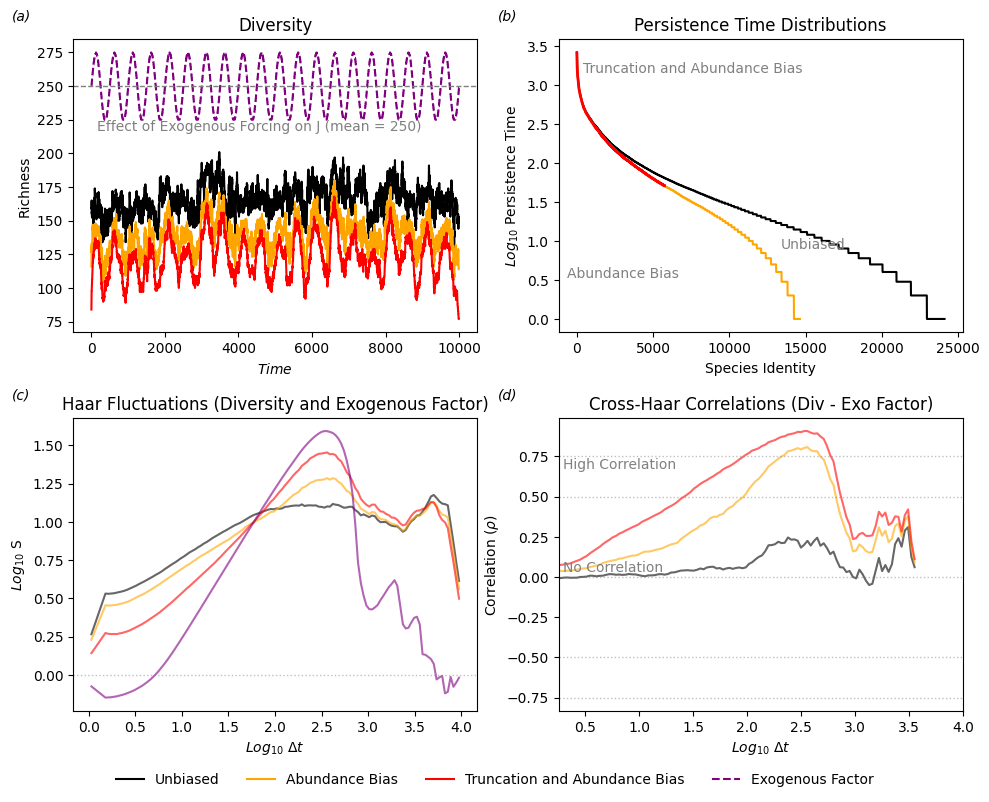

In [ ]:
# Main Figure 3
cmap = plt.get_cmap('magma', 3)
colors = [cmap(i) for i in range(3)]  # 3 variants: Unbiased, Abundance Bias, Truncation+Abundance
colors = ["black", "orange", "red"]
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
K = 10 # Convolution kernal window size

### a
# Diversity Curves
axs[0, 0].plot(np.arange(len(unbiased_r2f3[0][5:-5])), unbiased_r2f3[0][5:-5], c=colors[0], label="Unbiased")
axs[0, 0].plot(np.arange(len(sp_r2f3[0][5:-5])), sp_r2f3[0][5:-5], c=colors[1], label="Abundance Bias")
axs[0, 0].plot(np.arange(len(ab_r2f3[0][5:-5])), ab_r2f3[0][5:-5], c=colors[2], label="Truncation and Abundance")
axs[0, 0].plot(np.arange(len(clim[2000:])), clim[2000:] - 750, c="purple", label="Exogenous Factor", linestyle = "dashed")
axs[0, 0].set_title("Diversity")
### b
# Persistence Curves
axs[0, 1].plot(np.log10(unbiased_curve[0]), c=colors[0])
axs[0, 1].plot(np.log10(sp_curve[0]), c=colors[1])
axs[0, 1].plot(np.log10(ab_curve[0]), c=colors[2], linewidth = 2)
axs[0, 1].set_title("Persistence Time Distributions")

# Convolution Kernel Window
### c
# Haar Diversity
axs[1, 0].plot(np.log10(unbiased_hr_2f3[0][:, 0]), np.convolve(np.log10(unbiased_hr_2f3[0][:, 1]), np.ones(K)/K, mode='same'), color=colors[0], alpha=0.6, label="Unbiased Diversity")
axs[1, 0].plot(np.log10(sp_hr_2f3[0][:, 0]), np.convolve(np.log10(sp_hr_2f3[0][:, 1]), np.ones(K)/K, mode='same'), color=colors[1], alpha=0.6, label="Abundance Bias Diversity")
axs[1, 0].plot(np.log10(ab_hr_2f3[0][:, 0]), np.convolve(np.log10(ab_hr_2f3[0][:, 1]), np.ones(K)/K, mode='same'), color=colors[2], alpha=0.6, label="Truncation and Abundance Bias Diversity")
axs[1, 0].set_title("Haar Fluctuations (Diversity and Exogenous Factor)")

# Climate
axs[1, 0].plot(np.log10(unb_clim[0][:, 0]), np.convolve(np.log10(unb_clim[0][:, 1]), np.ones(K)/K, mode='same'), color="purple", alpha=0.6, label="Exogenous Factor") 

### d
# Cross-Haar Correlations
# Climate
axs[1, 1].plot(np.log10(unb_clim[0][:, 0]),  np.convolve(un_corr_dif_clim[0], np.ones(K)/K, mode='same'), color=colors[0], alpha=0.6)
axs[1, 1].plot(np.log10(unb_clim[0][:, 0]),  np.convolve(sp_corr_dif_clim[0], np.ones(K)/K, mode='same'), color=colors[1], alpha=0.6)
axs[1, 1].plot(np.log10(unb_clim[0][:, 0]),  np.convolve(ab_corr_dif_clim[0], np.ones(K)/K, mode='same'), color=colors[2], alpha=0.6)
axs[1, 1].set_title("Cross-Haar Correlations (Div - Exo Factor)")
# Add horizontal reference lines
for y in [0.75, -0.75, 0.5, -0.5, 0]:
    axs[1, 1].axhline(y, color="gray", linestyle=':', linewidth=1, alpha=0.5)

# Set layout
fig.tight_layout()

# Shared legend outside the plot
fig.legend(["Unbiased", "Abundance Bias", "Truncation and Abundance Bias", "Exogenous Factor"], 
           loc='lower center', ncol=4, frameon=False, bbox_to_anchor=(0.5, -0.01))

# labels
axs[0,0].set_xlabel(r'$Time$')
axs[0,0].set_ylabel(r'Richness')
axs[0,1].set_xlabel(r'Species Identity')
axs[0,1].set_ylabel(r'$Log_{10}$ Persistence Time')

axs[1,0].set_xlabel(r'$Log_{10}$ $\Delta t$')
axs[1,0].set_ylabel(r'$Log_{10}$ S')
axs[1,1].set_xlabel(r'$Log_{10}$ $\Delta t$')
axs[1,1].set_ylabel(r'Correlation $(\rho)$')

subplot_letters = [
"(a)", "(b)","(c)", "(d)"
]

# Plot Letters
for i, ax_row in enumerate(axs):
    for j, ax in enumerate(ax_row):
        idx = i * 2 + j
        ax.text(-0.15, 1.1, subplot_letters[idx], transform=ax.transAxes,
            fontsize=10, fontstyle='italic', va='top', ha='left')

# Figures Text Captions 
font_s = 10

#(a)
axs[0, 0].text(0.06, 0.7, "Effect of Exogenous Forcing on J (mean = 250)",transform=axs[0,0].transAxes,color='grey',fontsize=font_s,va='center',ha='left')
axs[0, 0].axhline(250, c = "grey",linewidth=1, linestyle="dashed")

# (b)
axs[0, 1].text(0.06, 0.9, "Truncation and Abundance Bias",transform=axs[0,1].transAxes,color='grey',fontsize=font_s,va='center',ha='left')
axs[0, 1].text(0.02, 0.2, "Abundance Bias",transform=axs[0,1].transAxes,color='grey',fontsize=font_s,va='center',ha='left')
axs[0, 1].text(0.55, 0.3, "Unbiased",transform=axs[0,1].transAxes,color='grey',fontsize=font_s,va='center',ha='left')
axs[1, 0].axhline(0, color="gray", linestyle=':', linewidth=1, alpha=0.5)

# (d)
axs[1, 1].text(0.01, 0.84, "High Correlation", transform=axs[1,1].transAxes,color='grey',fontsize=font_s,va='center',ha='left')
axs[1, 1].text(0.01, 0.49, "No Correlation", transform=axs[1,1].transAxes,color='grey',fontsize=font_s,va='center',ha='left')
axs[1, 1].set_xlim(0.25, 4)

plt.tight_layout(h_pad=0.75, w_pad=0.4)
plt.subplots_adjust(bottom=0.1)  # Extra space for legend
plt.savefig(tiff_save_path_1, format='png', dpi=300, bbox_inches='tight',transparent=True)